In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq
import matplotlib
from itertools import combinations
import os
from scipy.linalg import svd
from scipy.ndimage import shift

# import scienceplots
# plt.style.use('science')


### non parametric regression
### nadaraya-watson kernel regression

sigma = 1
gaus = lambda x: np.exp(-0.5 * (x / sigma) ** 2) # kernel gaussian function

#plt.plot(np.linspace(-2, 2, 100), gaus(np.linspace(-2, 2, 100) - 1))

def m(X, x, y): # estimator
    output = []
    if type(X) != np.ndarray:
          X = np.array([X])
    den = np.ones_like(x)
    num = np.ones_like(x)
    for j in range(len(X)):
            num = gaus(X[j] - x) * y
            den = gaus(X[j] - x)
            output.append(np.sum(num) / np.sum(den))
    return np.array(output)

x_smooth = np.linspace(0, 400, 2000)

# ratchet v1

In [ ]:
raiz = os.getcwd()

Dr = 0.005

os.chdir(raiz)
raiz_nueva = raiz + '/Dr_' + str(Dr)
os.chdir(raiz_nueva)
print(raiz_nueva)

In [2]:
### DATA IMPORT

rho_exp = np.load('rho_exp.npy')
J_exp = np.load('J_exp.npy')
gs_exp = np.load('gs_exp.npy')

N_sims = len(rho_exp)
Lx = 400
dx = 1
x = np.arange(0, Lx + dx, dx)
Nx = len(x)

def g_x(x, g_s, g_c = 0.5): # external current
    return -(g_c + g_s) * (np.heaviside((x-180), 0) - np.heaviside((x-220), 0)) + (g_s)

rho_min = 0.1 # density limits for the approximation
rho_max = 0.75
rho_est_arr = np.linspace(rho_min, rho_max, 50) #density values for integration limits

In [ ]:
### CASE: LAMBDA AND GAMMA CONSTANTS

# mobility is treated as proportional to rho

gam_exp = []
lam_exp = []
erf_exp = []
cov_exp = []

print("sim", "|" , "gamma", "|" , "lambda")

for i in range(len(rho_exp)):
#for i in range(1):
    rho = rho_exp[i]
    J = J_exp[i]
    gs = gs_exp[i]
    
    # non-parametric functions
    rho_non_par = lambda X: m(X, x, rho)
    j_non_par = lambda X: m(X, x, J)
    rho_g = lambda X: rho_non_par(X) * g_x(X, gs)
    
    # derivative rho
    d_rho = np.gradient(rho_non_par(x_smooth), x_smooth)
    d_rho_non_par = lambda X: m(X, x_smooth, d_rho)

    d2_rho = np.gradient(np.gradient(rho_non_par(x_smooth), x_smooth), x_smooth)
    d2_rho_non_par = lambda X: m(X, x_smooth, d2_rho)

    # plt.figure()
    # plt.plot(x, rho_non_par(x))
    # plt.plot(x, d_rho_non_par(x))
    # plt.plot(x, d2_rho_non_par(x))

    A = []
    B = []
    erf = []

    for rho_est in rho_est_arr:
        
        rho_zero = lambda X: rho_non_par(X) - rho_est
        rho_j = lambda X: j_non_par(X) / rho_non_par(X)

        # determination of integration limits
        a = brentq(rho_zero, 0, 180) # left limit
        b = brentq(rho_zero, 180, 400) # right limit

        # integrals for current
        integral_j, err = quad(rho_j, a, b)
        integral_rho_g, err = quad(g_x, a, b, args=gs)

        # values of A and B
        a0 = -(d2_rho_non_par(b) - d2_rho_non_par(a))
        a1 = (d_rho_non_par(b) ** 2 - d_rho_non_par(a) ** 2)
        b = -integral_j - integral_rho_g
        A.append([a0[0], a1[0]])
        B.append(b)
    
    A = np.array(A)
    B = np.array(B)

    U, s, Vh = svd(A, full_matrices=False)

    gam, lam = Vh.T @ np.diag(1 / s) @ U.T @ B
    gam_exp.append(round(gam, 2))
    lam_exp.append(round(lam, 2))



    cov = Vh @ np.diag(1 / s**2) @ Vh.T
    cov_exp.append(cov)
    erf = B - A@[gam, lam]
    erf_exp.append(erf)

    print(i, "|" , gam, "|" , lam, 2)

sim | gamma | lambda
0 | -168.4367389686026 | 1300.0957317585846 2
1 | -123.27021166853882 | 43.70158441980402 2
2 | 53.93767582174233 | -83.32947633721827 2
3 | 97.34766487344905 | -143.9074895157786 2
4 | -143.23040965260608 | 999.0779307654774 2
5 | -156.97945154023859 | 1407.8970797949735 2
6 | -182.13176566452327 | 237.62054244657008 2
7 | -98.65712206694347 | 197.8305631225868 2
8 | 38.03643236566026 | -39.07338749226654 2
9 | 47.11216775133691 | -163.40097651451936 2
10 | 100.62764870580082 | -255.46794530076068 2
11 | 98.70268056664611 | -370.65241896652816 2


[1300.1, 43.7, -83.33]
[-143.91, 999.08, 1407.9]
[237.62, 197.83, -39.07]
[-163.4, -255.47, -370.65]


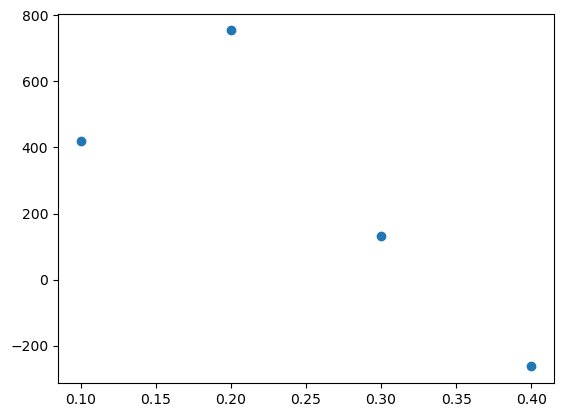

In [5]:
np.save('lam_exp.npy', np.array(lam_exp))
np.save('gam_exp.npy', np.array(gam_exp))
np.save('erf_cte.npy', np.array(erf_exp))
np.save('cov_cte.npy', cov_exp)


g = [0.1, 0.2, 0.3, 0.4]
lam_avg = []
lam_std = []


for i in range(4):
    print(lam_exp[3*i:3*i+3])
    lam_avg.append(np.mean(lam_exp[3*i:3*i+3]))
    lam_std.append(np.std(lam_exp[3*i:3*i+3]))

plt.plot(g, lam_avg, 'o')


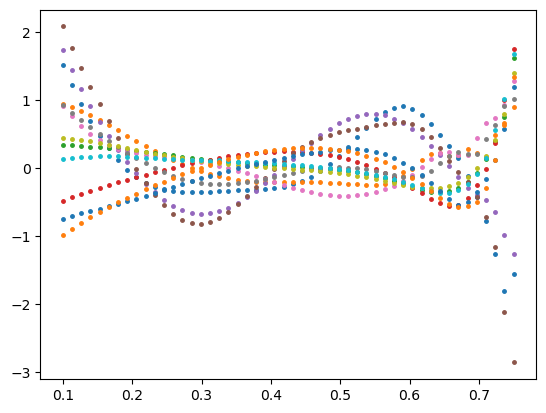

In [6]:
for erf in erf_exp:
    plt.plot(rho_est_arr, erf, 'o', ms=2.5)

In [7]:
### CASE: LAMBDA AND GAMMA DENSITY DEPENDENT

# mobility is treated as proportional to rho

a0_exp = []
a1_exp = []

for i in range(len(rho_exp)):

    rho = rho_exp[i]
    J = J_exp[i]
    gs = gs_exp[i]
    
    # non-parametric functions
    rho_non_par = lambda X: m(X, x, rho)
    j_non_par = lambda X: m(X, x, J)
    rho_g = lambda X: rho_non_par(X) * g_x(X, gs)
    
    # derivative rho
    d_rho = np.gradient(rho_non_par(x_smooth), x_smooth)
    d_rho_non_par = lambda X: m(X, x_smooth, d_rho)

    d2_rho = np.gradient(np.gradient(rho_non_par(x_smooth), x_smooth), x_smooth)
    d2_rho_non_par = lambda X: m(X, x_smooth, d2_rho)

    # plt.figure()
    # plt.plot(x, rho_non_par(x))
    # plt.plot(x, d_rho_non_par(x))
    # plt.plot(x, d2_rho_non_par(x))

    for rho_est in rho_est_arr:
        
        rho_zero = lambda X: rho_non_par(X) - rho_est
        rho_j = lambda X: j_non_par(X) / rho_non_par(X)

        # determination of integration limits
        a = brentq(rho_zero, 0, 180) # left limit
        b = brentq(rho_zero, 180, 400) # right limit

        # integrals for current
        integral_j, err = quad(rho_j, a, b)
        integral_rho_g, err = quad(g_x, a, b, args=gs)

        # values of A and B
        a0 = -(d2_rho_non_par(b) - d2_rho_non_par(a))
        a1 = (d_rho_non_par(b) ** 2 - d_rho_non_par(a) ** 2)
        b = -integral_j - integral_rho_g

        a0_exp.append(a0[0] / b)
        a1_exp.append(a1[0] / b)
    

# System of equations

# Matrix build
N = len(rho_est_arr) # number of rho evaluated
M = N_sims # number of simulations

A = np.zeros((M*N, 2*N))

print(len(a0_exp))

for i in range(N): # Recorre rho
    for k in range(M): # Recorre experimentos
        A[k + i*M, 2*i] = a0_exp[k * N + i]
        A[k + i*M, 2*i+1] = a1_exp[k * N + i]

d = np.ones(M*N)

# Descomposición SVD: A = U @ S @ Vt

U, s, Vt = np.linalg.svd(A, full_matrices=False)
S = np.diag(s)

#Encontrar lambda y gamma
# Resolver sistema A * b = d para b

V = np.transpose(Vt)
Ut = np.transpose(U)
S_1 = np.diag(1/s)

b = V @ S_1 @ Ut @ d

eta = np.zeros(N)
gam = np.zeros(N)

for i in range(N):
    gam[i] = b[2 * i]
    eta[i] = b[2 * i + 1]

cov = V @ np.diag(1 / s ** 2) @V.T

600


(100, 100)


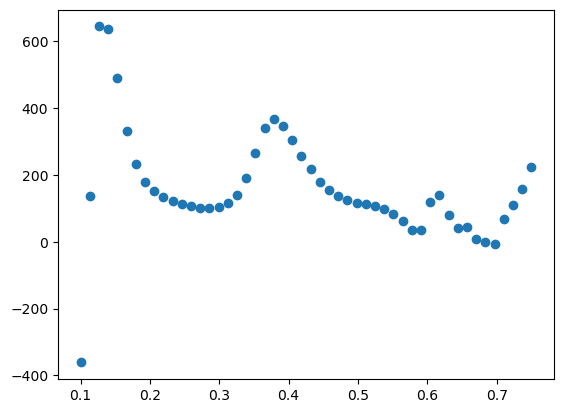

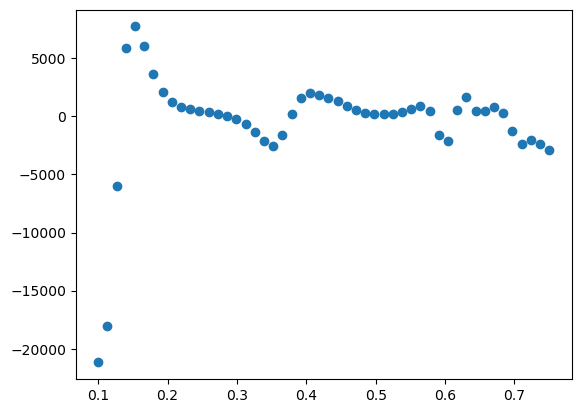

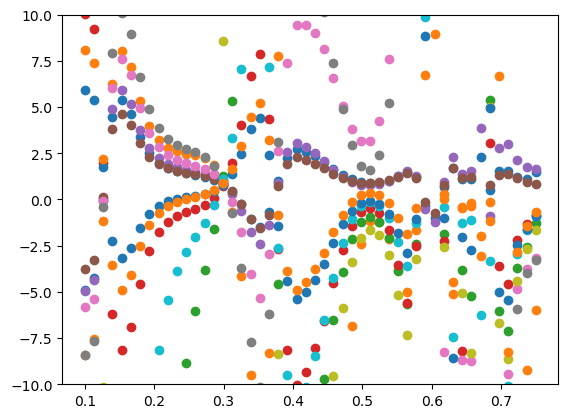

In [8]:
print(np.shape(cov))

plt.figure()
plt.plot(rho_est_arr, gam, "o")

lam = eta - 0.5 * np.gradient(gam, rho_est_arr)


erf = np.zeros((M, N))

for k in range(M):
    for i in range(N):
        erf[k, i] = 1 - gam[i] *  a0_exp[k * N + i] + lam[i] * a1_exp[k * N + i]


plt.figure()
plt.plot(rho_est_arr, lam, "o")

plt.figure()
for k in range(M):
    plt.plot(rho_est_arr, erf[k, :], 'o')
plt.ylim(-10, 10)

np.save('lam_rho.npy', lam)
np.save('gam_rho.npy', gam)
np.save('rho_0.npy', rho_est_arr)
np.save('erf.npy', erf)
np.save('cov_rho.npy', np.array(cov))

# ratchet v2

### creación datos

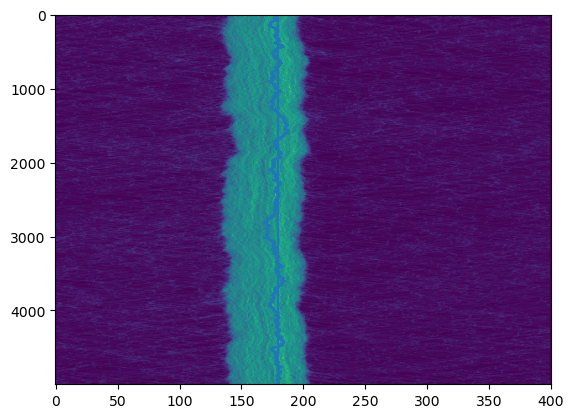

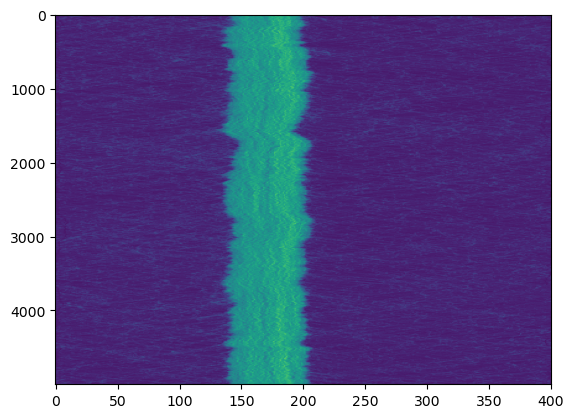

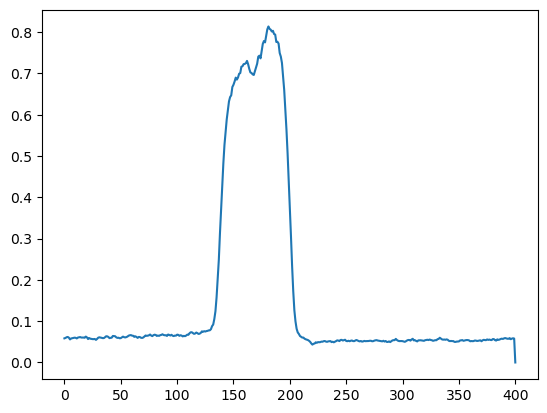

In [2]:
t_plot = np.arange(0, 10001, 1)
to = 5000

rho_t = np.load('1101' + '/data_phi_t.npy')

cent_rho = np.zeros_like(rho_t[to:-1])

x = np.arange(0, 401, 1)
x_center = 180
cm_list = []

for t in range(rho_t[to:-1].shape[0]):
    rho = rho_t[t+to]
    cm = np.sum(x * rho) / np.sum(rho)
    cm_list.append(cm)
    disp = x_center - cm
    cent_rho[t] = shift(rho, shift=disp, mode='grid-wrap')



plt.figure()
plt.imshow(rho_t[to:-1], aspect='auto')
plt.plot(cm_list, t_plot[to:-2] - to)
plt.axvline(180)

plt.figure()
plt.imshow(cent_rho, aspect='auto')

plt.figure()
plt.plot(np.mean(rho_t[to:-1], axis=0))

In [3]:
### Dr = 0.01

sim_list = ['1101', '1102', '1103', '1104']

rho_exp = []
j_exp = []

t_plot = np.arange(0, 10001, 1)
to = 5000

for sim in sim_list:
    rho_t = np.load(sim + '/data_phi_t.npy')
    j_t = np.load(sim + '/data_Jx_t.npy')

    rho_exp.append(np.mean(rho_t[to:-1], axis=0))
    j_exp.append(np.mean(j_t[to:-1], axis=0))

os.makedirs('Dr_0.01_v2', exist_ok=True)
np.save('Dr_0.01_v2/rho_exp.npy', np.array(rho_exp))
np.save('Dr_0.01_v2/J_exp.npy', np.array(j_exp))

### Dr = 0.005

sim_list = ['1201', '1202', '1203', '1204']

rho_exp = []
j_exp = []

t_plot = np.arange(0, 10001, 1)

to = 5000

for sim in sim_list:
    rho_t = np.load(sim + '/data_phi_t.npy')
    j_t = np.load(sim + '/data_Jx_t.npy')

    rho_exp.append(np.mean(rho_t[to:-1], axis=0))
    j_exp.append(np.mean(j_t[to:-1], axis=0))

os.makedirs('Dr_0.005_v2', exist_ok=True)
np.save('Dr_0.005_v2/rho_exp.npy', np.array(rho_exp))
np.save('Dr_0.005_v2/J_exp.npy', np.array(j_exp))

### estimación

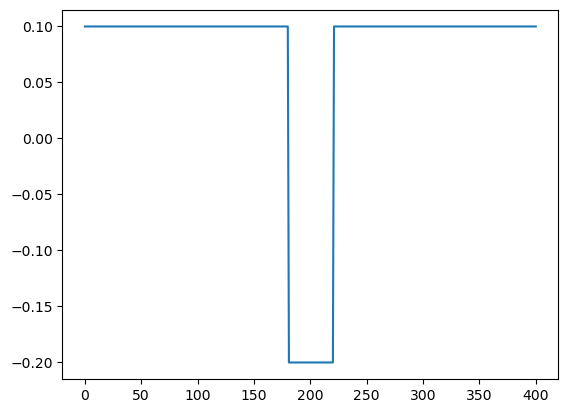

In [ ]:
N_sims = len(rho_exp)
Lx = 400
dx = 1
x = np.arange(0, Lx + dx, dx)
Nx = len(x)

def g_x(x, g): # external current
    return -(1.5 * g) * (np.heaviside((x-180), 0) - np.heaviside((x-220), 0)) + 0.5* g

rho_min = 0.1 # density limits for the approximation
rho_max = 0.7
rho_est_arr = np.linspace(rho_min, rho_max, 50) #density values for integration limits

plt.plot(g_x(x, 0.2))

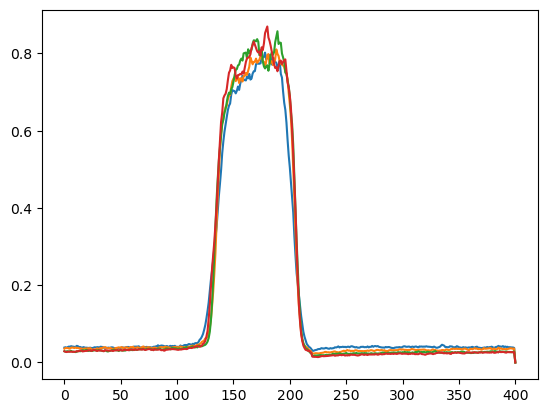

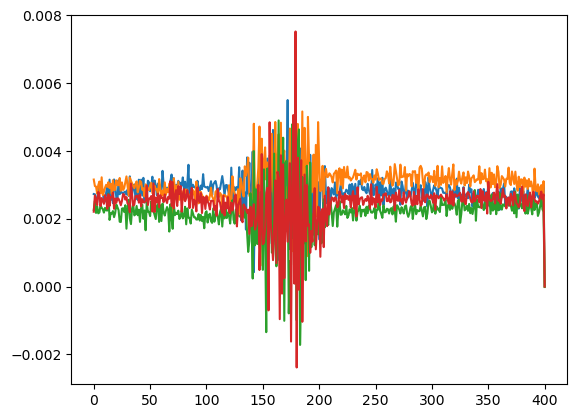

In [33]:
### Data import

Dr = '0.005'

rho_exp = np.load('Dr_' + Dr + '_v2/rho_exp.npy')
J_exp = np.load('Dr_' + Dr + '_v2/J_exp.npy')

g_exp = [0.2, 0.3, 0.4, 0.5]

plt.figure()
for rho in rho_exp:
    plt.plot(rho)

plt.figure()
for j in J_exp:
    plt.plot(j)

In [34]:
### CASE: LAMBDA AND GAMMA CONSTANTS

# mobility is treated as proportional to rho

gam_exp = []
lam_exp = []
erf_exp = []
cov_exp = []

print("sim", "|" , "gamma", "|" , "lambda")

for i in range(len(rho_exp)):
#for i in range(1):
    rho = rho_exp[i]
    J = J_exp[i]
    g = g_exp[i]
    
    # non-parametric functions
    rho_non_par = lambda X: m(X, x, rho)
    j_non_par = lambda X: m(X, x, J)
    rho_g = lambda X: rho_non_par(X) * g_x(X, g)
    
    # derivative rho
    d_rho = np.gradient(rho_non_par(x_smooth), x_smooth)
    d_rho_non_par = lambda X: m(X, x_smooth, d_rho)

    d2_rho = np.gradient(np.gradient(rho_non_par(x_smooth), x_smooth), x_smooth)
    d2_rho_non_par = lambda X: m(X, x_smooth, d2_rho)

    # plt.figure()
    # plt.plot(x, rho_non_par(x))
    # plt.plot(x, d_rho_non_par(x))
    # plt.plot(x, d2_rho_non_par(x))

    A = []
    B = []
    erf = []

    for rho_est in rho_est_arr:
        
        rho_zero = lambda X: rho_non_par(X) - rho_est
        rho_j = lambda X: j_non_par(X) / rho_non_par(X)

        # determination of integration limits
        a = brentq(rho_zero, 0, 180) # left limit
        b = brentq(rho_zero, 180, 400) # right limit

        # integrals for current
        integral_j, err = quad(rho_j, a, b)
        integral_rho_g, err = quad(g_x, a, b, args=g)

        # values of A and B
        a0 = -(d2_rho_non_par(b) - d2_rho_non_par(a))
        a1 = (d_rho_non_par(b) ** 2 - d_rho_non_par(a) ** 2)
        b = -integral_j - integral_rho_g
        A.append([a0[0], a1[0]])
        B.append(b)
    
    A = np.array(A)
    B = np.array(B)

    U, s, Vh = svd(A, full_matrices=False)

    gam, lam = Vh.T @ np.diag(1 / s) @ U.T @ B
    gam_exp.append(round(gam, 2))
    lam_exp.append(round(lam, 2))



    cov = Vh @ np.diag(1 / s**2) @ Vh.T
    cov_exp.append(cov)
    erf = B - A@[gam, lam]
    erf_exp.append(erf)

    print(i, "|" , gam, "|" , lam, 2)

print(cov_exp)

sim | gamma | lambda
0 | 5.42582308879045 | -217.7438648823702 2
1 | -20.589691971799652 | 213.98853472370666 2
2 | -22.448656835285444 | 335.5756022079438 2
3 | -14.167299201714911 | 295.1118625321526 2
[array([[ 1603.96319105,   611.79801731],
       [  611.79801731, 37000.06163111]]), array([[1839.90898534,   56.93711226],
       [  56.93711226, 9676.38406341]]), array([[ 750.25636882,  -13.18301484],
       [ -13.18301484, 5817.33469065]]), array([[ 381.56158473,   14.61985231],
       [  14.61985231, 2847.84758979]])]


In [35]:
np.save('Dr_' + Dr + '_v2/gam_exp.npy', gam_exp)
np.save('Dr_' + Dr + '_v2/lam_exp.npy', lam_exp)
np.save('Dr_' + Dr + '_v2/erf_exp.npy', erf_exp)
np.save('Dr_' + Dr + '_v2/cov_exp.npy', cov_exp)
np.save('Dr_' + Dr + '_v2/rho_0.npy', rho_est_arr)




Text(0.5, 0, '$g$')

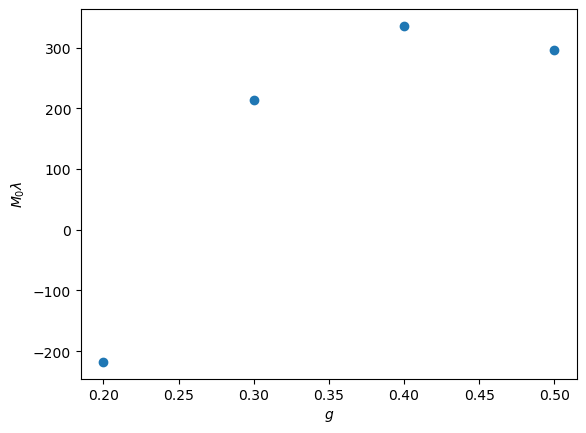

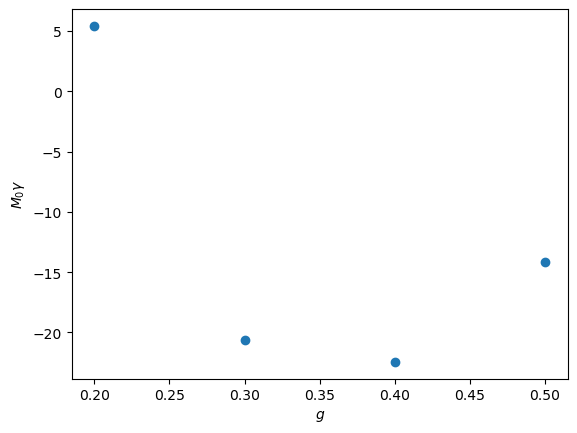

In [38]:
plt.figure()
plt.plot(g_exp, lam_exp, 'o')
plt.ylabel(r'$M_0 \lambda$')
plt.xlabel(r'$g$')

#plt.xlim(0, 0.51)

plt.figure()
plt.plot(g_exp, gam_exp, 'o')
# plt.xlim(0, 0.51)
plt.ylabel(r'$M_0 \gamma$')
plt.xlabel(r'$g$')


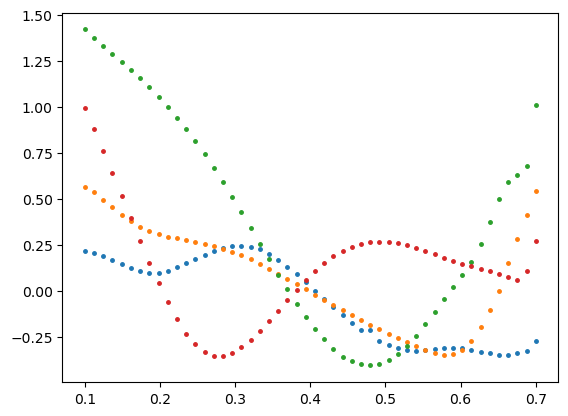

In [37]:
for erf in erf_exp:
    plt.plot(rho_est_arr, erf, 'o', ms=2.5)